# Frequency Detection

In [69]:
# Imports
from __future__ import division
from numpy.fft import rfft
from numpy import argmax, mean, diff, log, nonzero, polyfit, arange, array
from scipy.signal import blackmanharris
from time import time
import sys



## Estimate frequency by counting zero crossings

Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
crossings = indices

More accurate, using linear interpolation to find intersample
zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)

Some other interpolation based on neighboring points might be better.
Spline, cubic, whatever

In [70]:
def freq_from_crossings(signal, fs):
    sig = array(signal)
    # Find all indices right before a rising-edge zero crossing
    indices = nonzero((sig[1:] >= 0) & (sig[:-1] < 0))[0]

    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]

    return fs / mean(diff(crossings))

## Estimate frequency from peak of FFT

Quadratic interpolation for estimating the true position of an
inter-sample maximum when nearby samples are known.

f is a vector and x is an index for that vector.

Returns $(v_x, v_y)$, the coordinates of the vertex of a parabola that goes
through point x and its two neighbors.

Example:
Defining a vector f with a local maximum at index 3 (= 6), find local
maximum if points 2, 3, and 4 actually defined a parabola.

In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]

In [4]: parabolic(f, argmax(f))

Out[4]: (3.2142857142857144, 6.1607142857142856)


In [71]:

def parabolic(f, x):
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)


Use the built-in polyfit() function to find the peak of a parabola

f is a vector and x is an index for that vector.

n is the number of samples of the curve used to fit the parabola.

In [72]:
def parabolic_polyfit(f, x, n):
    a, b, c = polyfit(arange(x-n//2, x+n//2+1), f[x-n//2:x+n//2+1], 2)
    xv = -0.5 * b/a
    yv = a * xv**2 + b * xv + c
    return (xv, yv)

The relevance of using a blackmanharris window must be investigated, if it is not used the time is reduced but the variance worsens almost 3 times and the value of the estimated frequency is affected downwards.

In [73]:
def freq_from_fft(sig, fs):
    # Compute Fourier transform of windowed signal
    windowed = sig * blackmanharris(len(sig))
    f = rfft(windowed)
    
    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f))  # Just use this for less-accurate, naive version
    print(F"Max index = {i}")
    true_i = parabolic(log(abs(f)), i)[0]
    print(F"Parabolic max index = {true_i}")

    # Convert to equivalent frequency
    return fs * true_i / len(windowed)

## Estimate frequency using autocorrelation

In [74]:
from scipy.signal import find_peaks

def compute_autocorrelation(signal):
    """Compute the autocorrelation of a signal."""
    autocorr = np.correlate(signal, signal, mode='full')
    return autocorr[len(autocorr)//2:]

def freq_from_autocorr(signal, sample_rate):
    """Compute the fundamental frequency from autocorrelation."""
    autocorr = compute_autocorrelation(signal)
    peaks, _ = find_peaks(autocorr)
    peak_index = peaks[0]  # Select the first peak
    lag = peak_index / sample_rate
    fundamental_frequency = 1 / lag
    return fundamental_frequency

## Estimate frequency using harmonic product spectrum (HPS)

In [75]:
def freq_from_HPS(sig, fs):
    windowed = sig * blackmanharris(len(sig))

    from pylab import subplot, plot, log, copy, show

    # harmonic product spectrum:
    c = abs(rfft(windowed))
    maxharms = 8
    subplot(maxharms, 1, 1)
    plot(log(c))
    for x in range(2, maxharms):
        try:
            a = copy(c[1::x])  # Should average or maximum instead of decimating
            #max(c[::x],c[1::x],c[2::x],...)
            c = c[:len(a)]
            i = argmax(abs(c))
            true_i = parabolic(abs(c), i)[0]
            print('Pass %d: %f Hz' % (x, fs * true_i / len(windowed)))
            c *= a
            subplot(maxharms, 1, x)
            plot(log(c))
        except:
            pass
    show()


## Running experiments

First we import a real set with 1000 measured data burst of 512 samples each.

In [76]:
filename = 'TxBurst.csv'
print('Reading file "%s"\n' % filename)
fs = float(100e6)
f = open(filename, 'r')
lines = f.readlines()
burst = [[int(x) for x in line.split('\r\n')[0].split(',')[6:]] for line in lines]


Reading file "TxBurst.csv"



Lets plot the first time series

Text(0, 0.5, 'Amplitude')

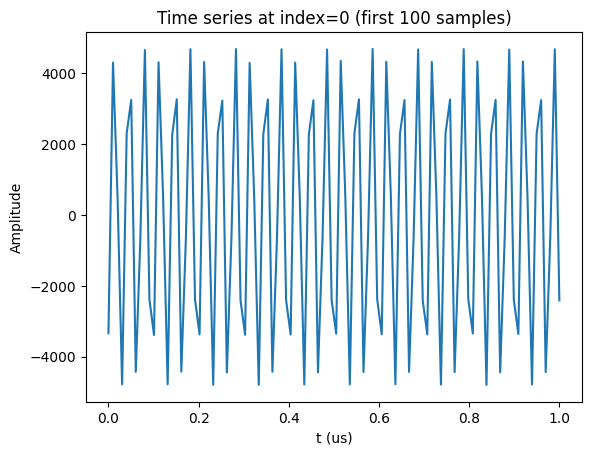

In [77]:
import matplotlib.pyplot as plt
import numpy as np

n_samples = 100
index = 0
t = np.linspace(0,n_samples/fs,n_samples)
plt.plot(t*1e6, burst[index][0:n_samples])

plt.title(F"Time series at index={index} (first {n_samples} samples)")
plt.xlabel("t (us)")
plt.ylabel("Amplitude")

Now, lets see the signal spectrum

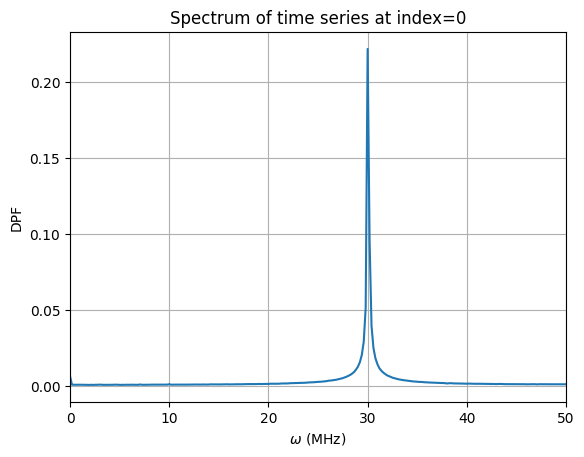

In [78]:
f = rfft(burst[index])
n_bins = len(f)
w = np.linspace(0,fs/2,n_bins)
plt.plot(w/1e6, abs(f)/sum(abs(f)))

plt.title(F"Spectrum of time series at index={index}")
plt.xlabel("$\omega$ (MHz)")
plt.ylabel("DPF")
plt.xlim((0,fs/2e6))
plt.grid()

Since we noticed a small DC component, lest find out the statistic of this value among all samples.

Average DC: -0.54%, std=0.071%


Text(0, 0.5, 'Frequency')

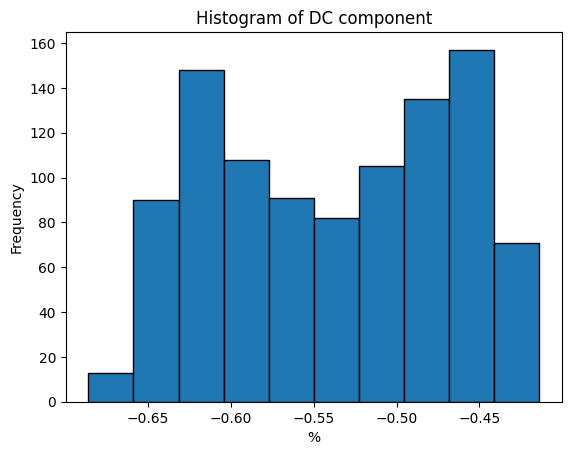

In [79]:
flat_list = [num for sublist in burst for num in sublist]
rango = max(flat_list) - min(flat_list)
dc = [100*sum(signal)/len(signal)/rango for signal in burst]
print(F"Average DC: {np.mean(dc):.2f}%, std={np.std(dc):.3f}%")
# Plotting the histogram
plt.hist(dc, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Labeling the plot
plt.title('Histogram of DC component')
plt.xlabel('%')
plt.ylabel('Frequency')

Although small, there is a clear negative bias in the digitalized signal.
Now lets compute the main frequency form above methods

511
Calculating frequency from FFT:
Max index = 153
Parabolic max index = 153.3052902759045
30001035 Hz
Time elapsed: 0.56 ms

Calculating frequency from zero crossings:
29999263 Hz
Time elapsed: 1.71 ms

Calculating frequency from autocorrelation:
33333333 Hz
Time elapsed: 0.75 ms

Calculating frequency from harmonic product spectrum:
Pass 2: 50458.990190 Hz
Pass 3: 1552.312925 Hz
Pass 4: 11.927163 Hz
Pass 5: 0.000000 Hz


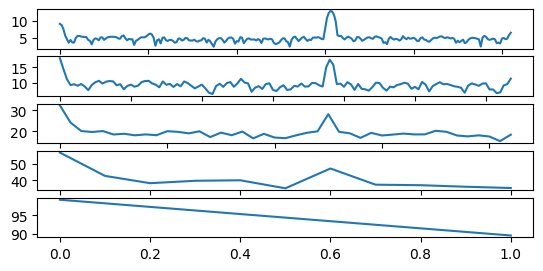

Time elapsed: 0.771 s



In [80]:
signal = array(burst[index])
print(len(burst[1]))
print('Calculating frequency from FFT:')
start_time = time()
print('%i Hz' % freq_from_fft(signal, fs))
print('Time elapsed: %.2f ms\n' % ((time() - start_time)*1000))

print('Calculating frequency from zero crossings:')
start_time = time()
print('%i Hz' % freq_from_crossings(signal, fs))
print('Time elapsed: %.2f ms\n' % ((time() - start_time)*1000))

print('Calculating frequency from autocorrelation:')
start_time = time()
print('%i Hz' % freq_from_autocorr(signal, fs))
print('Time elapsed: %.2f ms\n' % ((time() - start_time)*1000))

print('Calculating frequency from harmonic product spectrum:')
start_time = time()
freq_from_HPS(signal, fs)
print('Time elapsed: %.3f s\n' % (time() - start_time))

From the previous run we can conclude that the computation based on FFT and zero crossings works quite well. In the autocorrelation case it seems that the resolution is very poor. The harmonic product spectrum case seems to be converging to low frequency values, if it is worth doing it, the implementation should be reviewed.

### Statistical analysis for FFT and Zero Crossings

Now we compare these methods in the complete set of 1000 burst

In [81]:
fft_freqs = []
start_time = time()
for signal in burst:
    fft_freqs.append(freq_from_fft(signal, fs))
fft_ave_time = (time() - start_time)*1000/len(burst) # ms

print(F"FFT mean freq={int(np.mean(fft_freqs))}Hz, std={int(np.std(fft_freqs))}Hz, time={fft_ave_time:0.3f}ms")

zc_freqs = []
start_time = time()
for signal in burst:
    zc_freqs.append(freq_from_crossings(signal, fs))
zc_ave_time = (time() - start_time)*1000/len(burst) # ms

print(F"Zero crossing mean freq={int(np.mean(zc_freqs))}Hz, std={int(np.std(zc_freqs))}Hz, time={zc_ave_time:0.3f}ms")


Max index = 153
Parabolic max index = 153.3052902759045
Max index = 153
Parabolic max index = 153.3062911838972
Max index = 153
Parabolic max index = 153.30501853809758
Max index = 153
Parabolic max index = 153.30569727749995
Max index = 153
Parabolic max index = 153.30657077749038
Max index = 153
Parabolic max index = 153.3055252493998
Max index = 153
Parabolic max index = 153.30600912160867
Max index = 153
Parabolic max index = 153.30508492898616
Max index = 153
Parabolic max index = 153.30613021861896
Max index = 153
Parabolic max index = 153.30542686008238
Max index = 153
Parabolic max index = 153.30542548582116
Max index = 153
Parabolic max index = 153.3051228132645
Max index = 153
Parabolic max index = 153.3055907895418
Max index = 153
Parabolic max index = 153.30461971645548
Max index = 153
Parabolic max index = 153.30570277174124
Max index = 153
Parabolic max index = 153.3046983822725
Max index = 153
Parabolic max index = 153.304809757223
Max index = 153
Parabolic max index = 1

We can see the superiority of FFT and at least the python implementation is faster. We have to make both implementations in *rust* and include them in the system.